# Impact of Numerical Parameters

This notebook investigates how the reference scenario evolves if we change:
- The number of correlated agents.
- The number of independent agents.
- The number of candidates.
- The number of training samples for trained aggregators.

The common point between the four studies above is that we use the same drawings of utilities and estimates. For example, an experiment with 40 candidates will share the exact same 20 first candidates than an experiment with 20 candidates only.

First we load some packages and the dataset built in the *reference scenario* notebook, which contains all inputs required for the analysis presented in this notebook.

In [1]:
import numpy as np
import dill as pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
import tikzplotlib
from multiprocess.pool import Pool

In [2]:
import embedded_voting as ev # Our own module

Direct load of some useful variables and functions.

In [3]:
from embedded_voting.experiments.aggregation import make_generator, make_aggs, f_max, f_renorm
from embedded_voting.experiments.aggregation import handles, colors, evaluate, default_order

In [4]:
with open('base_case_data.pkl', 'rb') as f:
    data = pickle.load(f)

## Correlated Agents

### Computation

In [5]:
n_c = 20
cor_size = [1] + [i for i in range(2, 31, 2)]

res = np.zeros((9,len(cor_size)))
with Pool() as p:
    for j, s in enumerate(cor_size):
        groups = [s] + [1]*4    
        voters = slice(30-groups[0], 30+len(groups)-1)
        training = data['training'][voters, :]
        testing = data['testing'][voters, :, :n_c]
        truth = data['truth'][:, :n_c]

        list_agg = make_aggs(groups)
        res[:, j] = evaluate(list_agg=list_agg, truth=truth, testing=testing, training=training, pool=p)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:18<00:00, 536.30it/s]


We save the results.

In [6]:
with open('correlated_agents.pkl', 'wb') as f:
    pickle.dump(res, f)

### Display

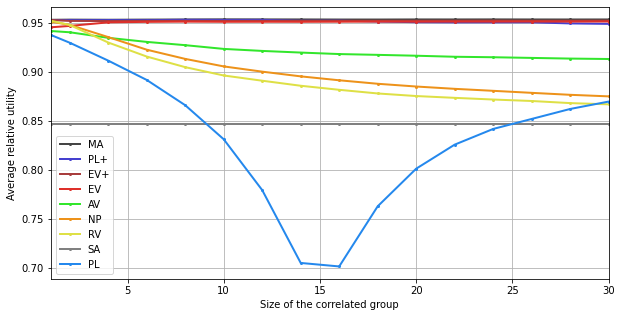

In [7]:
plt.figure(figsize=(10,5))
for i, agg in enumerate(list_agg):
    plt.plot(cor_size, res[i], "o-", color=colors[agg.name], label=handles[agg.name], 
             linewidth=2, markersize=2)

plt.legend()
plt.xlabel("Size of the correlated group")
plt.ylabel("Average relative utility")
plt.xticks(range(5,31,5), range(5,31,5))
plt.xlim(1,30)
plt.grid()
tikzplotlib.save("correlated_agents.tex", axis_height ='6cm', axis_width ='8cm')
# save figure
plt.savefig("correlated_agents.png", dpi=300)
plt.show()

## Independent Agents

### Computation

In [8]:
ind_size = [0, 1] + [i for i in range(2, 21, 2)]
res = np.zeros((9,len(ind_size)))

In [9]:
with Pool() as p:
    for j, indep in enumerate(ind_size):
        groups = [20] + [1]*indep
        voters = slice(30-groups[0], 30+len(groups)-1)
        training = data['training'][voters, :]
        testing = data['testing'][voters, :, :n_c]
        truth = data['truth'][:, :n_c]

        list_agg = make_aggs(groups)
        res[:, j] = evaluate(list_agg=list_agg, truth=truth, testing=testing, training=training, pool=p)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:20<00:00, 491.89it/s]


We save the results.

In [10]:
with open('independent_agents.pkl', 'wb') as f:
    pickle.dump(res, f)

### Display

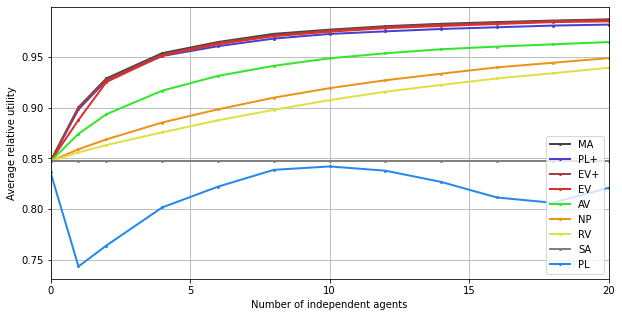

In [11]:
plt.figure(figsize=(10,5))
for i, agg in enumerate(list_agg):
    plt.plot(ind_size, res[i], "o-", color=colors[agg.name], label=handles[agg.name], 
             linewidth=2, markersize=2)

plt.legend()
plt.xlabel("Number of independent agents")
plt.ylabel("Average relative utility")
plt.xticks(range(0,21,5), range(0,21,5))
plt.xlim(0,20)
# plt.ylim(0.5)
plt.grid()
tikzplotlib.save("independents_agents.tex", axis_height ='6cm', axis_width ='8cm')
# save figure
plt.savefig("independents_agents.png", dpi=300)
plt.show()

## Candidates

### Computation

In [12]:
cand_size = [2,3,4,5,10,15,20,25,30,35,40,45,50]
res = np.zeros((9,len(cand_size)))

In [13]:
groups = [20] + [1]*4
voters = slice(30-groups[0], 30+len(groups)-1)
with Pool() as p:
    for j, n_c in enumerate(cand_size):
        training = data['training'][voters, :]
        testing = data['testing'][voters, :, :n_c]
        truth = data['truth'][:, :n_c]
        list_agg = make_aggs()
        res[:, j] = evaluate(list_agg=list_agg, truth=truth, testing=testing, training=training, pool=p)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [01:10<00:00, 141.72it/s]


We save the results.

In [14]:
with open('candidates.pkl', 'wb') as f:
    pickle.dump(res, f)

### Display

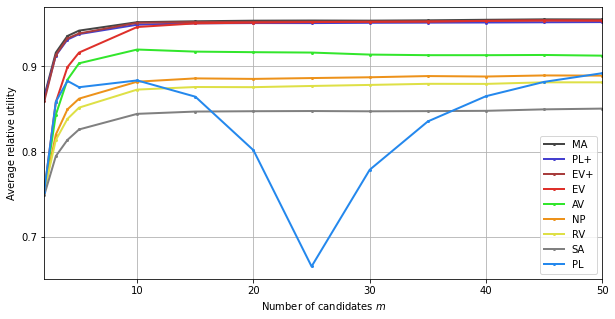

In [15]:
plt.figure(figsize=(10,5))
for i, agg in enumerate(list_agg):
    plt.plot(cand_size, res[i], "o-", color=colors[agg.name], label=handles[agg.name], 
             linewidth=2, markersize=2)

plt.legend()
plt.xlabel("Number of candidates $m$")
plt.ylabel("Average relative utility")
plt.xticks(range(0,51,10), range(0,51,10))
plt.yticks([0.7,0.8,0.9], [0.7,0.8,0.9])
plt.xlim(2,50)
# plt.ylim(0.6)
plt.grid()
tikzplotlib.save("candidates.tex", axis_height ='6cm', axis_width ='8cm')
# save figure
plt.savefig("candidates.png", dpi=300)
plt.show()

## Training Size

Note: due to space constraints, the following analysis, which studies the convergence speed of training for EV+ and PL+,  is not reported in the paper.

### Computation

In [16]:
from copy import copy
train_size = [0,20,40,60,100,140,300,620,1260]
results = np.zeros((2,len(train_size)))
n_c = 20

for j, train in enumerate(train_size):
    training = data['training'][voters, :train]
    testing = data['testing'][voters, :, :n_c]
    truth = data['truth'][:, :n_c]
    n_tries = testing.shape[1]

    list_agg =  [ev.Aggregator(rule=ev.RuleRatingsHistory(rule=ev.RuleMLEGaussian(), f=f_renorm), 
                               name="PL+"),
                ev.Aggregator(rule=ev.RuleFastNash(), name="EV+")]


    if training.shape[1]:
        for i in range(2):
            _ = list_agg[i](training).winner_

    sa = groups[0]-1 # index of the last agent from the group
    # We run the simulations
    for index_try in tqdm(range(n_tries)):
        ratings_candidates = testing[:, index_try, :]
        # Welfare
        welfare = ev.RuleSumRatings()(ev.Ratings([truth[index_try, :]])).welfare_
        # We run the aggregators, and we look at the welfare of the winner
        for k,agg in enumerate(list_agg):
            agg2 = copy(agg)
            w = agg2(ratings_candidates).winner_
            results[k, j] += welfare[w]
res = results/n_tries

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [06:01<00:00, 27.63it/s]


We save the results.

In [17]:
with open('training.pkl', 'wb') as f:
    pickle.dump(res, f)

### Display 

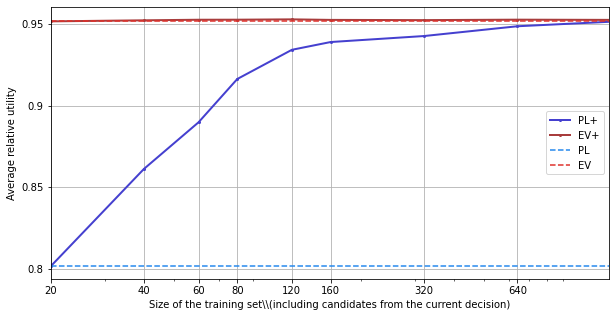

In [18]:
plt.figure(figsize=(10,5))
for i, agg in enumerate(list_agg):
    plt.plot([x+20 for x in train_size], res[i], "o-", color=colors[agg.name], 
             label=handles[agg.name], linewidth=2, markersize=2)

for i, agg in enumerate(list_agg):
    plt.plot([x+20 for x in train_size], [res[i][0]]*len(train_size), "--", 
             color=colors[agg.name[:2]], label=handles[agg.name[:2]])


plt.legend()
plt.xlabel("Size of the training set\\\\(including candidates from the current decision)")
plt.ylabel("Average relative utility")
plt.xscale("log")
plt.xticks([x+20 for x in train_size], [x+20 for x in train_size])
plt.yticks([0.8,0.85,0.9,0.95], [0.8,0.85,0.9,0.95])
plt.xlim(20,1260)
# plt.ylim(0.5)
plt.grid()
tikzplotlib.save("training.tex")
# save figure
plt.savefig("training.png", dpi=300)
plt.show()

We can see that, at least in the reference scenario, EV+ doesn't actually need to be trained. PL+ does.